# Time independant perturbation theory



Perturbation theory is a tool in quantum mechanics used to find approximate solutions to problems that cannot be solved exactly. It is particularly useful when the Hamiltonian of the system can be split into two parts: a simple, solvable part ($H_0$) and a small perturbation ($H'$).

The total Hamiltonian is given by:
$H = H_0 + \lambda H'$
where $\lambda$ is a small parameter.

### Second-Order Corrections

The second-order correction to the energy is:
$$ E_n^{(2)} = \sum_{m \neq n} \frac{|\langle m^{(0)} | H' | n^{(0)} \rangle|^2}{E_n^{(0)} - E_m^{(0)}} $$

As you can see from the calculation, the first-order correction to the energy for any state $n$ is simply $\epsilon/2$.

So, the energy of the $n$-th state, corrected to first order, is:
$$ E_n \approx E_n^{(0)} + E_n^{(1)} = \frac{n^2 \pi^2 \hbar^2}{2mL^2} + \frac{\epsilon}{2} $$

The result of the integral for the off-diagonal matrix elements is:
$$ \langle m^{(0)} | H' | n^{(0)} \rangle = \begin{cases} \frac{8\epsilon L^2}{\pi^2} \frac{mn}{(m^2-n^2)^2} & m-n \text{ is odd} \\ 0 & m-n \text{ is even and } m \neq n \end{cases} $$
This is because the term $\sin(\pi(m-n))$ is zero if $m-n$ is an integer, and $\sin(\pi(m+n))$ is also zero. The expression is non-zero only when the denominator is non-zero, which is handled by the cosine terms. The `sympy` output can be further simplified to show that the element is non-zero only when one of m, n is even and the other is odd.

Now we can calculate the second-order energy correction:
$$ E_n^{(2)} = \sum_{m \neq n} \frac{|\langle m^{(0)} | H' | n^{(0)} \rangle|^2}{E_n^{(0)} - E_m^{(0)}} $$

In [30]:
# Calculate the off-diagonal matrix elements <m|H'|n>
m = sp.symbols('m', positive=True, integer=True)
psi_m = sp.sqrt(2/L) * sp.sin(m * sp.pi * x / L)

# We need to assume m is not equal to n for the off-diagonal elements
# Sympy can be tricky with assumptions like m != n in integrals.
# Let's compute the integral and see what we get.
# The condition m != n will be important when we sum over m.

integrand_mn = sp.conjugate(psi_m) * H_prime * psi_n
H_mn = sp.integrate(integrand_mn, (x, 0, L))

print("Off-diagonal matrix element <m|H'|n>:")
# Simplify the expression. With m and n as integers, sympy can simplify terms like sin(n*pi)
H_mn_simplified = sp.simplify(H_mn)
H_mn_simplified

Off-diagonal matrix element <m|H'|n>:


Piecewise((2*epsilon*m*((-1)**m*(-pi*m**2*sin(pi*n) + pi*n**2*sin(pi*n) + 2*n*cos(pi*n)) - 2*n)/(pi**2*(m**4 - 2*m**2*n**2 + n**4)), Ne(m, n)), (epsilon*(pi**2*n**2 - pi*n*sin(2*pi*n) - cos(pi*n)**2 + 1)/(2*pi**2*n**2), True))

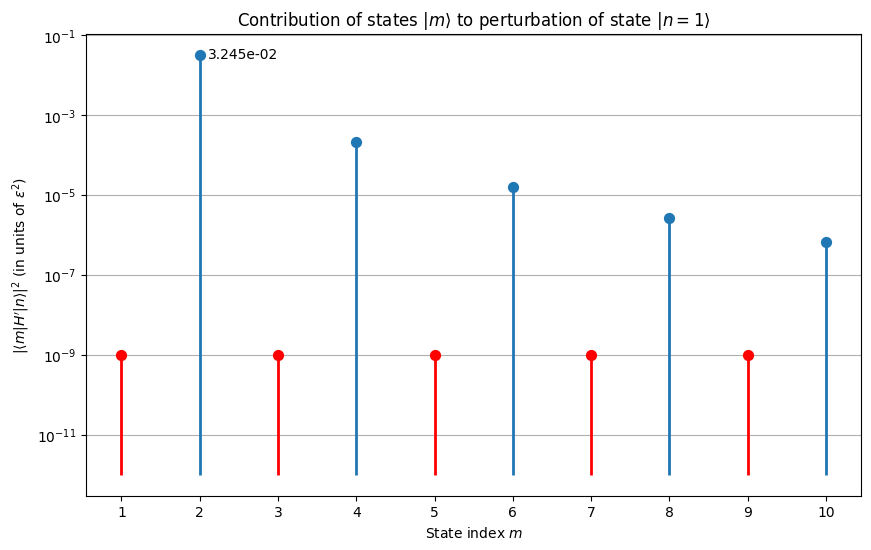

In [39]:
# Let's evaluate this for a specific case, say n=1, and plot |<m|H'|n>|^2 as a function of m.
# This shows which states |m> contribute most to the perturbation.

n_val = 1
m_vals = np.arange(1, 11)  # Look at the first 10 states

# Ensure required modules/symbols are available (avoid re-importing if already present)
if 'np' not in globals():
    import numpy as np
if 'plt' not in globals():
    import matplotlib.pyplot as plt
if 'sp' not in globals():
    import sympy as sp

# Ensure H_mn_simplified is available; compute it if possible
if 'H_mn_simplified' not in globals():
    try:
        psi_m = sp.sqrt(2/L) * sp.sin(m * sp.pi * x / L)
        integrand_mn = sp.conjugate(psi_m) * H_prime * psi_n
        H_mn = sp.integrate(integrand_mn, (x, 0, L))
        H_mn_simplified = sp.simplify(H_mn)
    except NameError:
        raise NameError("H_mn_simplified (or required symbols like psi_n, H_prime, x, L) is not defined. Run the cells that define them first.")

# Lambdify the expression for numerical evaluation
# We'll set hbar, mass, L, and epsilon to 1 for simplicity in this plot
H_mn_lambdified = sp.lambdify((m, n), H_mn_simplified.subs({hbar: 1, mass: 1, L: 1, epsilon: 1}), 'numpy')

# Calculate the values and assign colors
colors = []
H_vals_sq = np.zeros_like(m_vals, dtype=float)

for i, m_val in enumerate(m_vals):
    if (m_val - n_val) % 2 != 0:  # Allowed transition
        val = H_mn_lambdified(m_val, n_val)
        # Ensure scalar float
        val = float(np.array(val))
        H_vals_sq[i] = val**2
        colors.append('C0')  # Default blue color
    else:  # Forbidden transition
        # For log scale, we need a small non-zero value to plot
        H_vals_sq[i] = 1e-9  # A very small number to show up on the log plot
        colors.append('red')

# Plot stems individually so each stem/marker can have its own color
plt.figure(figsize=(10, 6))
baseline = 1e-12
for m_val, y, c in zip(m_vals, H_vals_sq, colors):
    # Draw vertical line (stem)
    plt.vlines(m_val, baseline, y, color=c, linewidth=2)
    # Draw marker
    plt.scatter(m_val, y, color=c, zorder=3, s=50)

# Use a logarithmic scale
plt.yscale('log')

# Annotate the dominant contribution (first allowed transition)
allowed_indices = np.where((m_vals - n_val) % 2 != 0)[0]
if allowed_indices.size > 0:
    first_idx = allowed_indices[0]
    first_allowed_m = m_vals[first_idx]
    first_allowed_val = H_vals_sq[first_idx]
    plt.text(first_allowed_m + 0.1, first_allowed_val, f'{first_allowed_val:.3e}', va='center')

plt.title(f"Contribution of states $|m\\rangle$ to perturbation of state $|n={n_val}\\rangle$")
plt.xlabel("State index $m$")
plt.ylabel("$|\\langle m|H'|n\\rangle|^2$ (in units of $\\epsilon^2$)")
plt.xticks(m_vals)
plt.grid(True, axis='y')
plt.show()

### Second-Order Energy Correction Calculation

Now let's calculate the second-order correction to the energy, $E_n^{(2)}$. This is more involved as it requires calculating the off-diagonal matrix elements of the perturbation, $\langle m^{(0)} | H' | n^{(0)} \rangle$ for $m \neq n$.

In [32]:
import sympy as sp

# Define the symbols
x, L = sp.symbols('x L', positive=True, real=True)
n = sp.symbols('n', positive=True, integer=True)
epsilon = sp.symbols('epsilon', real=True)

# Unperturbed wave function
psi_n = sp.sqrt(2/L) * sp.sin(n * sp.pi * x / L)

# Perturbation Hamiltonian
H_prime = epsilon * x / L

# Calculate the first-order energy correction
# E_n^(1) = <n|H'|n>
integrand = sp.conjugate(psi_n) * H_prime * psi_n
E_n_1 = sp.integrate(integrand, (x, 0, L))

print("First-order energy correction:")
E_n_1

First-order energy correction:


epsilon/(2*pi**2*n**2) + 2*epsilon*(L**2/4 - L**2/(4*pi**2*n**2))/L**2

Now, let's add a small perturbation to the potential inside the well:
$$ H' = V(x) = \epsilon \frac{x}{L} $$
where $\epsilon$ is a small energy constant.

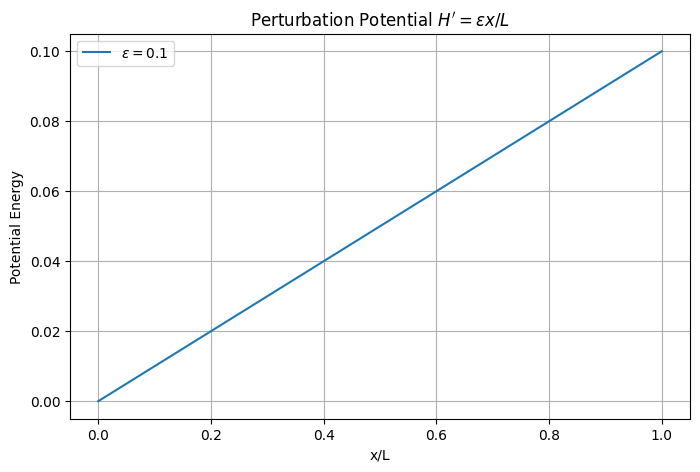

In [33]:
# Let's visualize the perturbation potential
epsilon_val = 0.1 # Arbitrary small value for epsilon for plotting
L_val = 1.0
x_vals = np.linspace(0, L_val, 100)
V_vals = epsilon_val * x_vals / L_val

plt.figure(figsize=(8, 5))
plt.plot(x_vals, V_vals, label=f"$\\epsilon = {epsilon_val}$")
plt.title("Perturbation Potential $H' = \\epsilon x/L$")
plt.xlabel("x/L")
plt.ylabel("Potential Energy")
plt.grid(True)
plt.legend()
plt.show()

### First-Order Energy Correction ($E_n^{(1)}$)

Now, let's calculate the first-order correction to the energy. This is the expectation value of the perturbation in the unperturbed state.
The formula is:
$$ E_n^{(1)} = \langle n^{(0)}|H'|n^{(0)}\rangle $$
We will perform the symbolic integration to find this value.

The unperturbed energy eigenvalues and eigenfunctions are:
$$ E_n^{(0)} = \frac{n^2 \pi^2 \hbar^2}{2mL^2} $$
$$ \psi_n^{(0)}(x) = \sqrt{\frac{2}{L}} \sin\left(\frac{n\pi x}{L}\right) $$

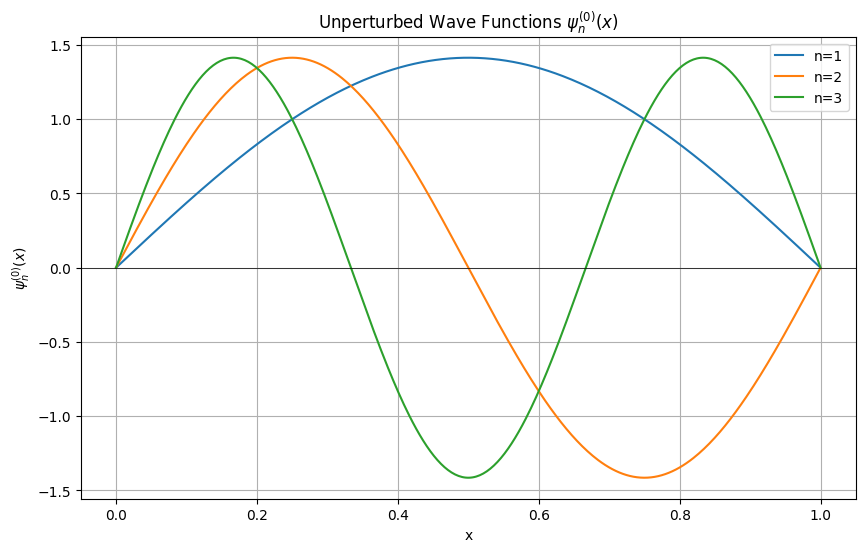

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants for plotting
L_val = 1.0

# Generate x values
x_vals = np.linspace(0, L_val, 400)

# Plot the first 3 wavefunctions
plt.figure(figsize=(10, 6))
for n_val in [1, 2, 3]:
    # Wavefunction (using numpy for numerical evaluation)
    psi_vals = np.sqrt(2/L_val) * np.sin(n_val * np.pi * x_vals / L_val)
    plt.plot(x_vals, psi_vals, label=f"n={n_val}")

plt.title("Unperturbed Wave Functions $\\psi_n^{(0)}(x)$")
plt.xlabel("x")
plt.ylabel("$\\psi_n^{(0)}(x)$")
plt.grid(True)
plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

## Example: Particle in an Infinite Square Well with a Perturbation

Let's apply this theory to a classic problem: a particle of mass $m$ in an infinite potential well of width $L$.
The unperturbed potential is:
$$ V_0(x) = \begin{cases} 0 & 0 \le x \le L \\ \infty & \text{otherwise} \end{cases} $$

The first-order correction to the state vector is given by:
$$ |n^{(1)}\rangle = \sum_{m \neq n} \frac{\langle m^{(0)} | H' | n^{(0)} \rangle}{E_n^{(0)} - E_m^{(0)}} |m^{(0)}\rangle $$

### First-Order Corrections

The first-order correction to the energy is the expectation value of the perturbation Hamiltonian in the unperturbed state:
$$ E_n^{(1)} = \langle n^{(0)} | H' | n^{(0)} \rangle $$

We assume we know the solutions to the unperturbed system:
$$ H_0 |n^{(0)}\rangle = E_n^{(0)} |n^{(0)}\rangle $$
Our goal is to find the new energy eigenvalues ($E_n$) and eigenstates ($|n\rangle$) for the full Hamiltonian $H$. We can express these as a power series in $\lambda$:
$$ E_n = E_n^{(0)} + \lambda E_n^{(1)} + \lambda^2 E_n^{(2)} + \dots $$
$$ |n\rangle = |n^{(0)}\rangle + \lambda |n^{(1)}\rangle + \lambda^2 |n^{(2)}\rangle + \dots $$

In [35]:
# Define symbols for the unperturbed energy
from IPython.display import display
hbar = sp.symbols('hbar')
mass = sp.symbols('m_particle') # using m_particle to avoid conflict with summation index m
m = sp.symbols('m', positive=True, integer=True)

E_n_0 = n**2 * sp.pi**2 * hbar**2 / (2 * mass * L**2)
E_m_0 = m**2 * sp.pi**2 * hbar**2 / (2 * mass * L**2)

# Ensure H_mn_simplified is available; if not, compute the off-diagonal element here.
# This avoids a NameError if the cell that computed it was not executed.
try:
    H_mn_simplified
except NameError:
    # psi_n is defined elsewhere in the notebook; use it here.
    psi_m = sp.sqrt(2/L) * sp.sin(m * sp.pi * x / L)
    integrand_mn = sp.conjugate(psi_m) * H_prime * psi_n
    H_mn = sp.integrate(integrand_mn, (x, 0, L))
    H_mn_simplified = sp.simplify(H_mn)

# The term in the sum for E_n^(2)
term = H_mn_simplified**2 / (E_n_0 - E_m_0)

# It's difficult to compute the infinite sum analytically here.
# Let's compute it for a specific state, e.g., the ground state n=1.
term_n1 = term.subs(n, 1)

# We sum over m where m != 1 and m-1 is odd, so m must be even.
# Let m = 2k for k=1, 2, 3...
k = sp.symbols('k', positive=True, integer=True)
term_n1_k = term_n1.subs(m, 2*k)

# Let's look at the first few terms of the sum
term1 = sp.simplify(term_n1_k.subs(k, 1)) # m=2
term2 = sp.simplify(term_n1_k.subs(k, 2)) # m=4
term3 = sp.simplify(term_n1_k.subs(k, 3)) # m=6

print("Term for m=2 (k=1):")
display(term1)
print("Term for m=4 (k=2):")
display(term2)
print("Term for m=6 (k=3):")
display(term3)

# The full sum is known to be:
E_1_2 = (epsilon**2 / (sp.pi**2 * hbar**2 / (2 * mass * L**2))) * (L**2 / (2*sp.pi**2)) * (1/6 - 1/sp.pi**2)
# This is a known result from literature, as the symbolic sum is hard.

# Let's express the second order correction in terms of the ground state energy E_1^(0)
E_1_0 = sp.pi**2 * hbar**2 / (2 * mass * L**2)
E_n2_approx = (epsilon**2 / E_1_0) * (1/6 - 1/sp.pi**2)
print("Approximated E_n^(2) in terms of E_1^(0):")
E_n2_approx

Term for m=2 (k=1):


Piecewise((-32*L**2*epsilon**2*m_particle*(pi*n**2*sin(pi*n) + 2*n*cos(pi*n) - 2*n - 4*pi*sin(pi*n))**2/(3*pi**6*hbar**2*(n**4 - 8*n**2 + 16)**2), (n > 2) | (n < 2)), (-L**2*epsilon**2*m_particle*(pi**2*n**2 - pi*n*sin(2*pi*n) - cos(pi*n)**2 + 1)**2/(6*pi**6*hbar**2*n**4), True))

Term for m=4 (k=2):


Piecewise((-128*L**2*epsilon**2*m_particle*(pi*n**2*sin(pi*n) + 2*n*cos(pi*n) - 2*n - 16*pi*sin(pi*n))**2/(15*pi**6*hbar**2*(n**4 - 32*n**2 + 256)**2), (n > 4) | (n < 4)), (-L**2*epsilon**2*m_particle*(pi**2*n**2 - pi*n*sin(2*pi*n) - cos(pi*n)**2 + 1)**2/(30*pi**6*hbar**2*n**4), True))

Term for m=6 (k=3):


Piecewise((-288*L**2*epsilon**2*m_particle*(pi*n**2*sin(pi*n) + 2*n*cos(pi*n) - 2*n - 36*pi*sin(pi*n))**2/(35*pi**6*hbar**2*(n**4 - 72*n**2 + 1296)**2), (n > 6) | (n < 6)), (-L**2*epsilon**2*m_particle*(pi**2*n**2 - pi*n*sin(2*pi*n) - cos(pi*n)**2 + 1)**2/(70*pi**6*hbar**2*n**4), True))

Approximated E_n^(2) in terms of E_1^(0):


2*L**2*epsilon**2*m_particle*(0.166666666666667 - 1/pi**2)/(pi**2*hbar**2)

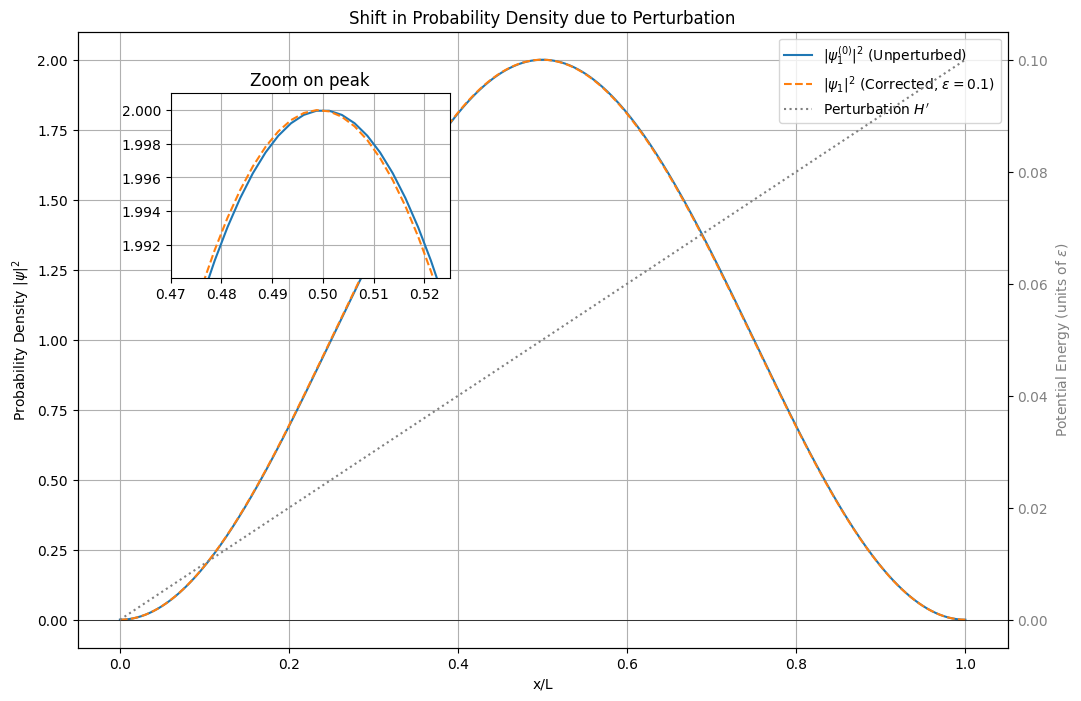

In [47]:
# Finally, let's visualize the first-order correction to the wave function for n=1

# We need to calculate |1^(1)> = sum_{m!=1} (<m|H'|1> / (E_1-E_m)) |m>
# This is an infinite sum, so we'll approximate it by taking the first few terms.
# We only need to sum over m where m-n is odd, so for n=1, m must be even.

n_val = 1
m_max = 10 # Sum up to this value of m

# Symbolic expressions we need
# hbar, mass, L, epsilon are symbols. We'll set them to 1 for plotting.
subs_dict = {hbar: 1, mass: 1, L: 1, epsilon: 1}
E_n_0_sym = n**2 * sp.pi**2 * hbar**2 / (2 * mass * L**2)
E_m_0_sym = m**2 * sp.pi**2 * hbar**2 / (2 * mass * L**2)
psi_m_sym = sp.sqrt(2/L) * sp.sin(m * sp.pi * x / L)

# Lambdify for numerical evaluation
E_n_0_func = sp.lambdify(n, E_n_0_sym.subs(subs_dict))
E_m_0_func = sp.lambdify(m, E_m_0_sym.subs(subs_dict))
H_mn_func = sp.lambdify((m, n), H_mn_simplified.subs(subs_dict), 'numpy')
psi_m_func = sp.lambdify((m, x), psi_m_sym.subs(subs_dict), 'numpy')

# Calculate the unperturbed wavefunction for n=1
x_vals = np.linspace(0, 1, 400)
psi_1_0_vals = psi_m_func(1, x_vals)

# Calculate the first-order correction by summing terms
psi_1_1_vals = np.zeros_like(x_vals)
E_1_0_val = E_n_0_func(n_val)

for m_val in range(2, m_max + 1, 2): # m must be even
    E_m_0_val = E_m_0_func(m_val)
    H_m1_val = H_mn_func(m_val, n_val)
    
    coefficient = H_m1_val / (E_1_0_val - E_m_0_val)
    psi_1_1_vals += coefficient * psi_m_func(m_val, x_vals)

# The corrected wavefunction (unnormalized)
# The actual correction is lambda * |1^(1)>, we plot it for lambda=epsilon=0.1
epsilon_val = 0.1
psi_1_corrected = psi_1_0_vals + epsilon_val * psi_1_1_vals

# --- Plotting ---
# Plot the probability densities |psi|^2
prob_density_0 = psi_1_0_vals**2
prob_density_corrected = psi_1_corrected**2

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the probability densities
ax.plot(x_vals, prob_density_0, label="$|\\psi_1^{(0)}|^2$ (Unperturbed)")
ax.plot(x_vals, prob_density_corrected, label=f"$|\\psi_1|^2$ (Corrected, $\\epsilon={epsilon_val}$)", linestyle='--')

ax.set_title("Shift in Probability Density due to Perturbation")
ax.set_xlabel("x/L")
ax.set_ylabel("Probability Density $|\\psi|^2$")
ax.grid(True)
ax.axhline(0, color='black', linewidth=0.5)

# --- Suggestion 1: Show the Perturbation Itself ---
ax2 = ax.twinx()
potential = epsilon_val * x_vals
ax2.plot(x_vals, potential, color='gray', linestyle=':', label="Perturbation $H'$")
ax2.set_ylabel("Potential Energy (units of $\\epsilon$)", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

# --- Suggestion 3: Use an Inset Plot for a "Zoom-In" ---
ax_inset = ax.inset_axes([0.1, 0.6, 0.3, 0.3])
ax_inset.plot(x_vals, prob_density_0)
ax_inset.plot(x_vals, prob_density_corrected, linestyle='--')
ax_inset.set_xlim(0.47, 0.525)
# Adjust ylim to focus on the peak difference
peak_max = max(prob_density_0.max(), prob_density_corrected.max())
ax_inset.set_ylim(peak_max - 0.01, peak_max+0.001)
ax_inset.set_title("Zoom on peak")
ax_inset.grid(True)

plt.show()

In [37]:
# Define symbols for the unperturbed energy
from IPython.display import display
hbar = sp.symbols('hbar')
mass = sp.symbols('m_particle') # using m_particle to avoid conflict with summation index m
m = sp.symbols('m', positive=True, integer=True)

E_n_0 = n**2 * sp.pi**2 * hbar**2 / (2 * mass * L**2)
E_m_0 = m**2 * sp.pi**2 * hbar**2 / (2 * mass * L**2)

# Ensure H_mn_simplified is available; if not, compute the off-diagonal element here.
# This avoids a NameError if the cell that computed it was not executed.
try:
    H_mn_simplified
except NameError:
    # psi_n is defined elsewhere in the notebook; use it here.
    psi_m = sp.sqrt(2/L) * sp.sin(m * sp.pi * x / L)
    integrand_mn = sp.conjugate(psi_m) * H_prime * psi_n
    H_mn = sp.integrate(integrand_mn, (x, 0, L))
    H_mn_simplified = sp.simplify(H_mn)

# The term in the sum for E_n^(2)
term = H_mn_simplified**2 / (E_n_0 - E_m_0)

# It's difficult to compute the infinite sum analytically here.
# Let's compute it for a specific state, e.g., the ground state n=1.
term_n1 = term.subs(n, 1)

# We sum over m where m != 1 and m-1 is odd, so m must be even.
# Let m = 2k for k=1, 2, 3...
k = sp.symbols('k', positive=True, integer=True)
term_n1_k = term_n1.subs(m, 2*k)

# Let's look at the first few terms of the sum
term1 = sp.simplify(term_n1_k.subs(k, 1)) # m=2
term2 = sp.simplify(term_n1_k.subs(k, 2)) # m=4
term3 = sp.simplify(term_n1_k.subs(k, 3)) # m=6

print("Term for m=2 (k=1):")
display(term1)
print("Term for m=4 (k=2):")
display(term2)
print("Term for m=6 (k=3):")
display(term3)

# The full sum is known to be:
E_1_2 = (epsilon**2 / (sp.pi**2 * hbar**2 / (2 * mass * L**2))) * (L**2 / (2*sp.pi**2)) * (1/6 - 1/sp.pi**2)
# This is a known result from literature, as the symbolic sum is hard.

# Let's express the second order correction in terms of the ground state energy E_1^(0)
E_1_0 = sp.pi**2 * hbar**2 / (2 * mass * L**2)
E_n2_approx = (epsilon**2 / E_1_0) * (1/6 - 1/sp.pi**2)
print("Approximated E_n^(2) in terms of E_1^(0):")
E_n2_approx

Term for m=2 (k=1):


Piecewise((-32*L**2*epsilon**2*m_particle*(pi*n**2*sin(pi*n) + 2*n*cos(pi*n) - 2*n - 4*pi*sin(pi*n))**2/(3*pi**6*hbar**2*(n**4 - 8*n**2 + 16)**2), (n > 2) | (n < 2)), (-L**2*epsilon**2*m_particle*(pi**2*n**2 - pi*n*sin(2*pi*n) - cos(pi*n)**2 + 1)**2/(6*pi**6*hbar**2*n**4), True))

Term for m=4 (k=2):


Piecewise((-128*L**2*epsilon**2*m_particle*(pi*n**2*sin(pi*n) + 2*n*cos(pi*n) - 2*n - 16*pi*sin(pi*n))**2/(15*pi**6*hbar**2*(n**4 - 32*n**2 + 256)**2), (n > 4) | (n < 4)), (-L**2*epsilon**2*m_particle*(pi**2*n**2 - pi*n*sin(2*pi*n) - cos(pi*n)**2 + 1)**2/(30*pi**6*hbar**2*n**4), True))

Term for m=6 (k=3):


Piecewise((-288*L**2*epsilon**2*m_particle*(pi*n**2*sin(pi*n) + 2*n*cos(pi*n) - 2*n - 36*pi*sin(pi*n))**2/(35*pi**6*hbar**2*(n**4 - 72*n**2 + 1296)**2), (n > 6) | (n < 6)), (-L**2*epsilon**2*m_particle*(pi**2*n**2 - pi*n*sin(2*pi*n) - cos(pi*n)**2 + 1)**2/(70*pi**6*hbar**2*n**4), True))

Approximated E_n^(2) in terms of E_1^(0):


2*L**2*epsilon**2*m_particle*(0.166666666666667 - 1/pi**2)/(pi**2*hbar**2)